## 传统QP算法求解硬间隔SVM的对偶问题

     pcost       dcost       gap    pres   dres
 0:  2.3071e+12 -3.6908e+14  1e+15  1e+00  7e-09
 1:  4.8049e+12 -1.5621e+14  3e+14  2e-01  6e-06
 2:  4.7729e+12 -3.0453e+13  5e+13  2e-02  9e-07
 3:  1.8462e+12 -8.1189e+12  1e+13  4e-03  2e-07
 4:  8.0185e+11 -3.7302e+12  5e+12  1e-03  5e-08
 5:  2.4921e+11 -1.4713e+12  2e+12  2e-09  2e-09
 6:  6.7483e+10 -3.9478e+11  5e+11  2e-10  1e-09
 7:  3.4619e+10 -1.8300e+11  2e+11  4e-11  9e-10
 8:  1.5881e+10 -1.0295e+11  1e+11  7e-10  1e-09
 9:  6.1330e+09 -2.8694e+10  3e+10  5e-10  9e-10
10:  3.7822e+09 -1.4757e+10  2e+10  2e-10  9e-10
11:  1.7326e+09 -7.0651e+09  9e+09  7e-10  9e-10
12:  5.1762e+08 -2.0309e+09  3e+09  2e-10  8e-10
13:  1.0663e+08 -2.2921e+08  3e+08  1e-10  4e-10
14:  1.6474e+07 -2.2114e+07  4e+07  1e-11  3e-10
15:  2.3016e+06 -2.7976e+06  5e+06  6e-11  1e-10
16:  2.9956e+05 -4.2678e+05  7e+05  4e-12  4e-11
17:  4.6136e+04 -1.0821e+05  2e+05  2e-11  2e-11
18:  1.3606e+04 -7.6668e+04  9e+04  9e-12  9e-12
19: -1.1743e+04 -7.74

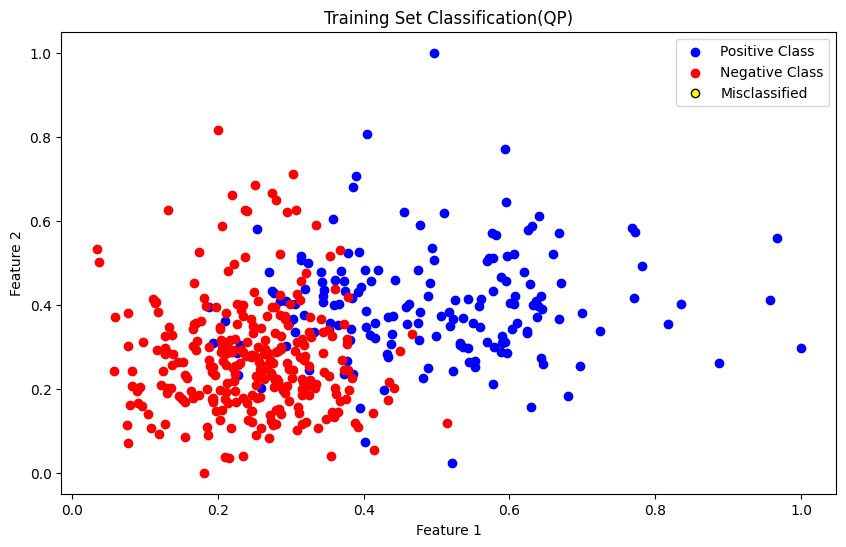

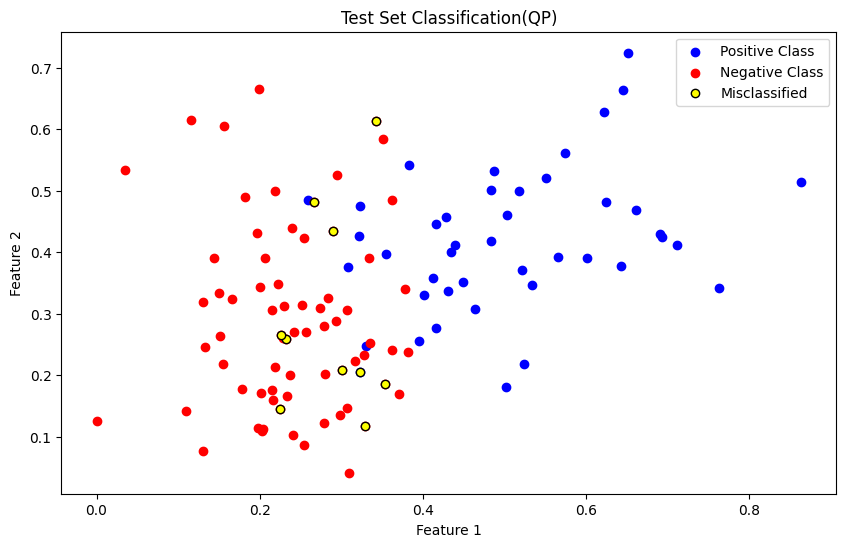

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# 读取数据
X_train = pd.read_csv('breast_cancer_Xtrain.csv').values
Y_train = pd.read_csv('breast_cancer_Ytrain.csv').values
X_test = pd.read_csv('breast_cancer_Xtest.csv').values
Y_test = pd.read_csv('breast_cancer_Ytest.csv').values

# 将Y_train和Y_test转换为适当的格式（即-1和1）
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

# 定义核函数（线性核）
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# 构建二次规划问题
m, n = X_train.shape
K = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        K[i, j] = linear_kernel(X_train[i], X_train[j])

P = matrix(np.outer(Y_train, Y_train) * K)
q = matrix(-np.ones(m))
G = matrix(np.vstack((-np.eye(m), np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * 1e6)))
A = matrix(Y_train, (1, m), 'd')
b = matrix(0.0)

# 求解二次规划问题
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x']).flatten()

# 计算权重向量和偏置
w = np.sum(alphas[:, np.newaxis] * Y_train[:, np.newaxis] * X_train, axis=0)
# 选择支持向量
sv = (alphas > 1e-5)
# 计算偏置
b = np.mean(Y_train[sv] - np.dot(X_train[sv], w))

# 打印计算出的权重向量和偏置
print("权重向量 w：", w)
print("偏置 b：", b)

# 定义预测函数
def predict(X):
    return np.sign(np.dot(X, w) + b)

# 预测并评估模型
Y_train_pred = predict(X_train)
Y_test_pred = predict(X_test)

train_accuracy = np.mean(Y_train_pred == Y_train)
test_accuracy = np.mean(Y_test_pred == Y_test)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 可视化训练集和测试集分类结果
def plot_classification_results(X, Y_true, Y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[Y_true == 1][:, 0], X[Y_true == 1][:, 1], color='blue', label='Positive Class')
    plt.scatter(X[Y_true == -1][:, 0], X[Y_true == -1][:, 1], color='red', label='Negative Class')
    plt.scatter(X[Y_true != Y_pred][:, 0], X[Y_true != Y_pred][:, 1], color='yellow', edgecolor='black', label='Misclassified')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_classification_results(X_train[:, :2], Y_train, Y_train_pred, 'Training Set Classification(QP)')
plot_classification_results(X_test[:, :2], Y_test, Y_test_pred, 'Test Set Classification(QP)')


## SMO计算参数

In [17]:
import numpy as np

def kernel(x1, x2):
    return np.dot(x1, x2.T)

def calculate_b(X, y, alphas, b, C, tol):
    m = len(y)
    b_new = 0
    b1 = []
    b2 = []

    for i in range(m):
        y_pred = np.sum(alphas * y * kernel(X, X[i])) + b
        if y[i] * y_pred - 1 < -tol:
            b1.append(b + y[i] - y_pred)
        elif y[i] * y_pred - 1 > tol:
            b2.append(b + y[i] - y_pred)

    if len(b1) > 0:
        b_new = np.mean(b1)
    elif len(b2) > 0:
        b_new = np.mean(b2)

    return b_new

def smo_svm(X, y, C, tol, max_passes):
    m, n = X.shape
    alphas = np.zeros(m)
    b = 0
    passes = 0

    while passes < max_passes:
        alpha_pairs_changed = 0
        for i in range(m):
            E_i = np.sum(alphas * y * kernel(X, X[i])) + b - y[i]
            if (y[i] * E_i < -tol and alphas[i] < C) or (y[i] * E_i > tol and alphas[i] > 0):
                j = np.random.randint(0, m)
                while j == i:
                    j = np.random.randint(0, m)

                E_j = np.sum(alphas * y * kernel(X, X[j])) + b - y[j]
                alpha_i_old, alpha_j_old = alphas[i], alphas[j]

                if y[i] != y[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[i] + alphas[j] - C)
                    H = min(C, alphas[i] + alphas[j])

                if L == H:
                    continue

                eta = 2 * kernel(X[i], X[j]) - kernel(X[i], X[i]) - kernel(X[j], X[j])
                if eta >= 0:
                    continue

                alphas[j] -= y[j] * (E_i - E_j) / eta
                alphas[j] = np.clip(alphas[j], L, H)

                if abs(alphas[j] - alpha_j_old) < 1e-5:
                    continue

                alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j])
                b1 = b - E_i - y[i] * (alphas[i] - alpha_i_old) * kernel(X[i], X[i]) - y[j] * (alphas[j] - alpha_j_old) * kernel(X[i], X[j])
                b2 = b - E_j - y[i] * (alphas[i] - alpha_i_old) * kernel(X[i], X[j]) - y[j] * (alphas[j] - alpha_j_old) * kernel(X[j], X[j])
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                alpha_pairs_changed += 1

        if alpha_pairs_changed == 0:
            passes += 1
        else:
            passes = 0

    return alphas, b

# Load the data
X_train = np.loadtxt('breast_cancer_Xtrain.csv', delimiter=',')
y_train = np.loadtxt('breast_cancer_Ytrain.csv', delimiter=',')

C = 1.0
tol = 1e-3
max_passes = 5

alphas, b = smo_svm(X_train, y_train, C, tol, max_passes)
print("Alphas:", alphas)
print("b:", b)


Alphas: [3.45117900e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 4.03310117e-01
 0.00000000e+00 

In [18]:
def predict(X, alphas, b, X_train, y_train):
    return np.sign(np.dot((alphas * y_train).T, kernel(X_train, X)) + b)

# Load test data
X_test = np.loadtxt('breast_cancer_Xtest.csv', delimiter=',')
y_test = np.loadtxt('breast_cancer_Ytest.csv', delimiter=',')

predictions = predict(X_test, alphas, b, X_train, y_train)

accuracy = np.mean(predictions == y_test)
print("Accuracy on test data:", accuracy)


Accuracy on test data: 0.9824561403508771


## 预测保存结果

In [19]:
# 预测函数
def predict(X, alphas, b, X_train, y_train):
    return np.sign(np.dot((alphas * y_train).T, kernel(X_train, X)) + b)

# 加载测试数据
X_test = np.loadtxt('breast_cancer_Xtest.csv', delimiter=',')
y_test = np.loadtxt('breast_cancer_Ytest.csv', delimiter=',')

# 对测试集进行预测
predictions = predict(X_test, alphas, b, X_train, y_train)

# 计算准确率
accuracy = np.mean(predictions == y_test)
print("Accuracy on test data:", accuracy)

# 将预测结果写入 result.csv 文件
np.savetxt('result.csv', predictions, delimiter=',', fmt='%d')

# 加载原始标签和预测标签
original_labels = y_test
predicted_labels = predictions

# 创建 DataFrame 来存储比较结果
comparison_df = pd.DataFrame({
    'Original': original_labels,
    'Predicted': predicted_labels
})

# 找出不同的标签
differences = comparison_df[comparison_df['Original'] != comparison_df['Predicted']]

# 输出不同标签的行数
print(f"Number of differences: {len(differences)}")

# 输出所有不同的标签
print("Differences between original and predicted labels:")
print(differences)



Accuracy on test data: 0.9824561403508771
Number of differences: 2
Differences between original and predicted labels:
    Original  Predicted
20       1.0       -1.0
77       1.0       -1.0


## 可视化训练集和测试集分类结果

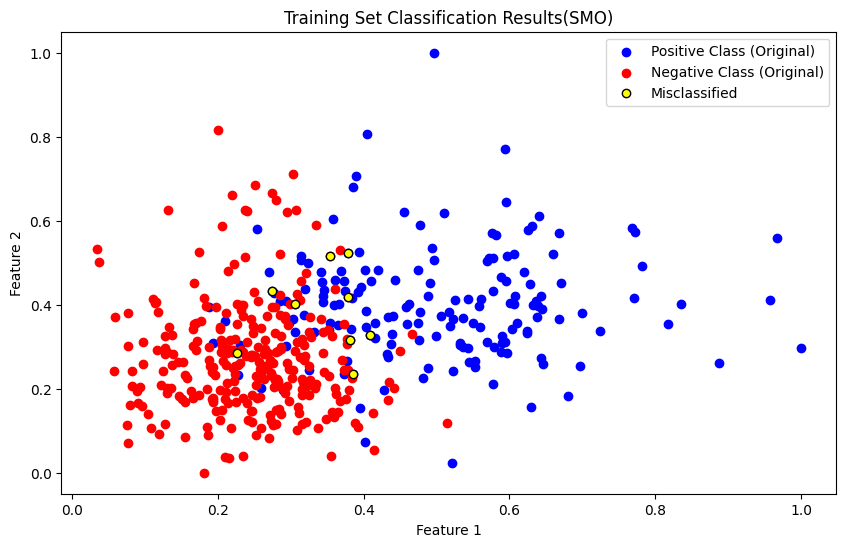

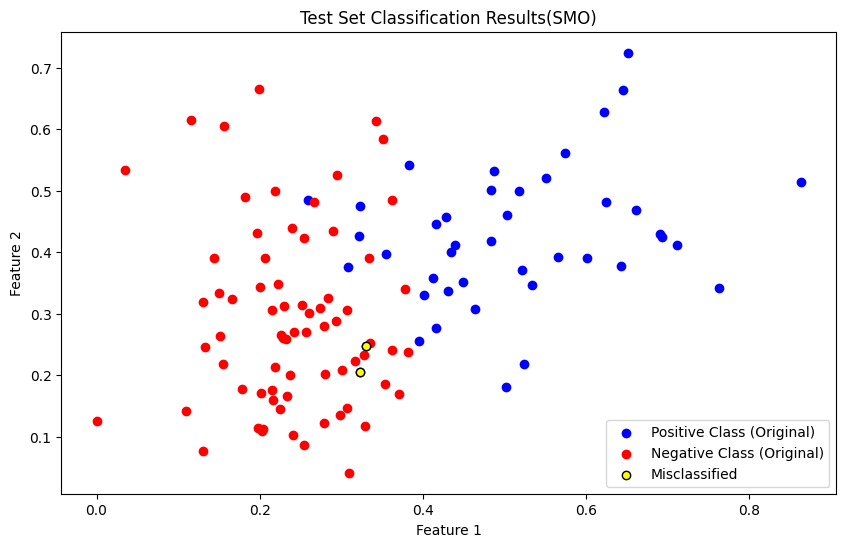

In [20]:
# 可视化训练集和测试集分类结果
def plot_classification_results(X, y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[y_true == 1][:, 0], X[y_true == 1][:, 1], color='blue', label='Positive Class (Original)')
    plt.scatter(X[y_true == -1][:, 0], X[y_true == -1][:, 1], color='red', label='Negative Class (Original)')
    plt.scatter(X[y_true != y_pred][:, 0], X[y_true != y_pred][:, 1], color='yellow', edgecolor='black', label='Misclassified')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_classification_results(X_train[:, :2], y_train, predict(X_train, alphas, b, X_train, y_train), 'Training Set Classification Results(SMO)')
plot_classification_results(X_test[:, :2], y_test, predictions, 'Test Set Classification Results(SMO)')

## 完整的代码

Alphas: [3.41573428e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.77555756e-17 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.33674223e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 

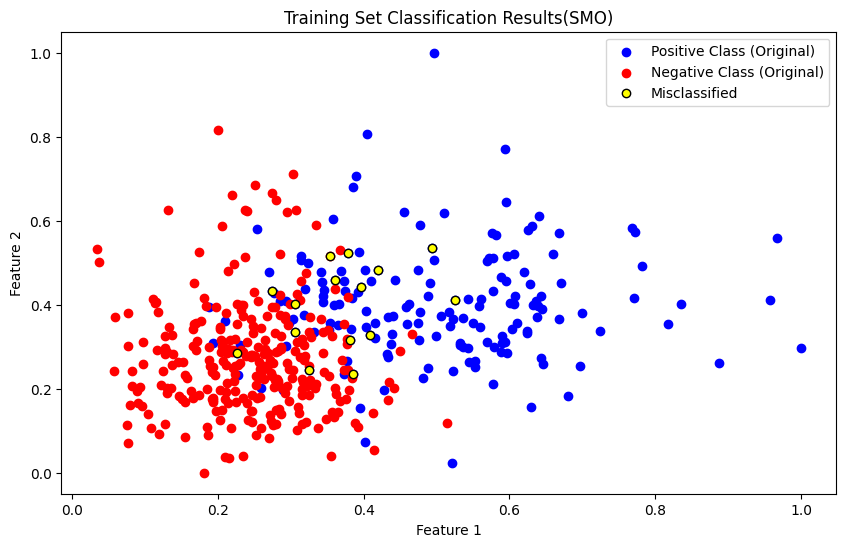

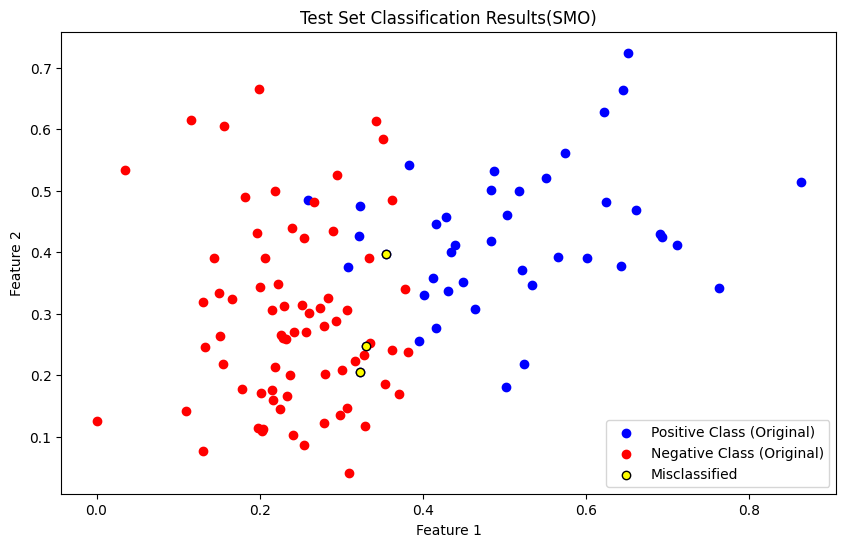

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义核函数（线性核）
def kernel(x1, x2):
    return np.dot(x1, x2.T)

# 计算偏置b
def calculate_b(X, y, alphas, b, C, tol):
    m = len(y)
    b_new = 0
    b1 = []
    b2 = []

    for i in range(m):
        y_pred = np.sum(alphas * y * kernel(X, X[i])) + b
        if y[i] * y_pred - 1 < -tol:
            b1.append(b + y[i] - y_pred)
        elif y[i] * y_pred - 1 > tol:
            b2.append(b + y[i] - y_pred)

    if len(b1) > 0:
        b_new = np.mean(b1)
    elif len(b2) > 0:
        b_new = np.mean(b2)

    return b_new

# SMO算法
def smo_svm(X, y, C, tol, max_passes):
    m, n = X.shape
    alphas = np.zeros(m)
    b = 0
    passes = 0

    while passes < max_passes:
        alpha_pairs_changed = 0
        for i in range(m):
            E_i = np.sum(alphas * y * kernel(X, X[i])) + b - y[i]
            if (y[i] * E_i < -tol and alphas[i] < C) or (y[i] * E_i > tol and alphas[i] > 0):
                j = np.random.randint(0, m)
                while j == i:
                    j = np.random.randint(0, m)

                E_j = np.sum(alphas * y * kernel(X, X[j])) + b - y[j]
                alpha_i_old, alpha_j_old = alphas[i], alphas[j]

                if y[i] != y[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[i] + alphas[j] - C)
                    H = min(C, alphas[i] + alphas[j])

                if L == H:
                    continue

                eta = 2 * kernel(X[i], X[j]) - kernel(X[i], X[i]) - kernel(X[j], X[j])
                if eta >= 0:
                    continue

                alphas[j] -= y[j] * (E_i - E_j) / eta
                alphas[j] = np.clip(alphas[j], L, H)

                if abs(alphas[j] - alpha_j_old) < 1e-5:
                    continue

                alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j])
                b1 = b - E_i - y[i] * (alphas[i] - alpha_i_old) * kernel(X[i], X[i]) - y[j] * (alphas[j] - alpha_j_old) * kernel(X[i], X[j])
                b2 = b - E_j - y[i] * (alphas[i] - alpha_i_old) * kernel(X[i], X[j]) - y[j] * (alphas[j] - alpha_j_old) * kernel(X[j], X[j])
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                alpha_pairs_changed += 1

        if alpha_pairs_changed == 0:
            passes += 1
        else:
            passes = 0

    return alphas, b

# 加载数据
X_train = np.loadtxt('breast_cancer_Xtrain.csv', delimiter=',')
y_train = np.loadtxt('breast_cancer_Ytrain.csv', delimiter=',')


# 训练参数
C = 1.0
tol = 1e-3
max_passes = 5

# 训练模型
alphas, b = smo_svm(X_train, y_train, C, tol, max_passes)
print("Alphas:", alphas)
print("b:", b)

# 预测函数
def predict(X, alphas, b, X_train, y_train):
    return np.sign(np.dot((alphas * y_train).T, kernel(X_train, X)) + b)

# 加载测试数据
X_test = np.loadtxt('breast_cancer_Xtest.csv', delimiter=',')
y_test = np.loadtxt('breast_cancer_Ytest.csv', delimiter=',')

# 将y_test转换为适当的格式（即-1和1）
y_test[y_test == 0] = -1

# 对测试集进行预测
predictions = predict(X_test, alphas, b, X_train, y_train)

# 计算准确率
accuracy = np.mean(predictions == y_test)
print("Accuracy on test data:", accuracy)

# 将预测结果写入 result.csv 文件
np.savetxt('result.csv', predictions, delimiter=',', fmt='%d')

# 加载原始标签和预测标签
original_labels = y_test
predicted_labels = predictions

# 创建 DataFrame 来存储比较结果
comparison_df = pd.DataFrame({
    'Original': original_labels,
    'Predicted': predicted_labels
})

# 找出不同的标签
differences = comparison_df[comparison_df['Original'] != comparison_df['Predicted']]

# 输出不同标签的行数
print(f"Number of differences: {len(differences)}")

# 输出所有不同的标签
print("Differences between original and predicted labels:")
print(differences)

# 可视化训练集和测试集分类结果
def plot_classification_results(X, y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[y_true == 1][:, 0], X[y_true == 1][:, 1], color='blue', label='Positive Class (Original)')
    plt.scatter(X[y_true == -1][:, 0], X[y_true == -1][:, 1], color='red', label='Negative Class (Original)')
    plt.scatter(X[y_true != y_pred][:, 0], X[y_true != y_pred][:, 1], color='yellow', edgecolor='black', label='Misclassified')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_classification_results(X_train[:, :2], y_train, predict(X_train, alphas, b, X_train, y_train), 'Training Set Classification Results(SMO)')
plot_classification_results(X_test[:, :2], y_test, predictions, 'Test Set Classification Results(SMO)')
